In [11]:
import os
import re
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(1)

In [12]:
#Let's get the data
def load_data(path="../data/train.tsv", length=5020):
    df = pd.read_csv(path, sep="\t")[:length]
    df.drop(['PhraseId','SentenceId'], axis=1, inplace=True)
    x, y = df["Phrase"].values, df["Sentiment"].values
    return (x, y)

x, y = load_data("../data/train.tsv")

def clean_text(x, y):
  x = [i.lower() for i in x]
  x = [re.sub(r'[^A-Za-z]+', ' ', i) for i in x]
  x_, y_ = [], []
  for i in range(len(x)):
    if x[i].split():
      x_.append(x[i])
      y_.append(y[i])
  return x_, y_

x, y = clean_text(x, y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

print(len(x), len(x_train), len(x_val))
print(x[:5], y[:5])

5000 4000 1000
['a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story ', 'a series of escapades demonstrating the adage that what is good for the goose', 'a series', 'a', 'series'] [1, 2, 2, 2, 2]


In [13]:
#Simple Dict for embedding
def build_dict(x):
    ret = []
    for i in x:
        ret += [j for j in i.split()]
    return list(set(ret))

d = build_dict(x)

word2idx = {d[i]:i for i in range(len(d))}

pad_idx = len(word2idx)

word2idx["padding"] = pad_idx

vocab_size = len(word2idx)

n_classes = 5

print(len(word2idx))


1459


In [29]:
#Build datalodaer
batch_size = 400

class mydataset(torch.utils.data.Dataset):
    def __init__(self, x:torch.Tensor, y:torch.Tensor, length_list):
        self.x = x
        self.y = y
        self.length_list = length_list
    def __getitem__(self, index):
        data = self.x[index]
        labels = self.y[index]
        length = self.length_list[index]
        return data, labels, length
    def __len__(self):
        return len(self.x)

def get_idx(word):
    try:
        return word2idx[word]
    except:
        return word2idx['unknown']

def sentence2vector(sentence):
    return [get_idx(word) for word in sentence.split()]

def padding(x, max_length):
    length = 0
    for i in range(max_length - len(x)):
        x.append(word2idx["padding"])
    return x

def get_dataloader(x, y):
    inputs = [sentence2vector(s) for s in x]

    length_list = [len(i) for i in inputs]

    max_length = max(length_list)

    inputs = torch.tensor([padding(s, max_length) for s in inputs])

    targets =  torch.tensor(y, dtype=torch.long)

    dataset = mydataset(inputs, targets, length_list)

    dataloader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=batch_size)

    return dataloader


train_dataloader = get_dataloader(x_train, y_train)

test_dataloader = get_dataloader(x_val, y_val)


In [9]:
#Implement LSTM for Classification Task ( Hidden is the presentation of the sentence)
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, vocab_size, target_size, dropout, embedding):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        if embedding is None:
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        else:
            self.word_embeddings = embedding
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, bidirectional=True)

        self.hidden2tag = nn.Linear(2 * hidden_dim, target_size)

    def forward(self, sentences, length_list):

        embeds = self.word_embeddings(sentences)

        packed_x = pack_padded_sequence(embeds, lengths=length_list, batch_first=True, enforce_sorted=False)

        packed_out, (h, C) = self.lstm(packed_x)
        y_ = self.hidden2tag(torch.cat((h[-2], h[-1]), dim=1))
        return y_


In [15]:
#test model

loss_function = nn.CrossEntropyLoss()

net = LSTM(embedding_dim=100, hidden_dim=20, num_layers=20,
            vocab_size=vocab_size, target_size=n_classes, dropout=0.6, embedding=None)

optimizer = optim.SGD(net.parameters(), lr=0.01)

for i, (inputs, targets, length_list) in enumerate(train_dataloader):
    net.zero_grad()
    
    probs = net(inputs, length_list)

    print(probs, targets)

    loss = loss_function(probs, targets)

    loss.backward()

    optimizer.step()
    break


tensor([[-0.0783, -0.0792, -0.0551, -0.1170,  0.0996],
        [-0.1149, -0.0845, -0.0536, -0.1312,  0.1032],
        [-0.0703, -0.0907, -0.0572, -0.1110,  0.0886],
        ...,
        [-0.0670, -0.0655, -0.0794, -0.1359,  0.0863],
        [-0.0904, -0.0534, -0.1008, -0.1590,  0.1177],
        [-0.1056, -0.0719, -0.0692, -0.1449,  0.0877]],
       grad_fn=<AddmmBackward>) tensor([2, 3, 2, 1, 2, 1, 1, 3, 1, 3, 2, 2, 3, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 2,
        2, 2, 1, 3, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 1, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 3, 2, 2, 2, 2, 0, 2, 2, 4, 4,
        1, 3, 2, 1, 1, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 4, 2, 3, 1, 1,
        2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 1, 2, 2, 3, 3, 1, 2, 0, 1, 2, 2, 2, 3, 2,
        2, 2, 2, 3, 2, 3, 2, 2, 2, 1, 2, 3, 0, 2, 4, 1, 0, 2, 1, 0, 2, 2, 1, 2,
        2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 4, 2, 3, 2, 1, 1, 1, 3, 2, 2, 2, 2, 2,
        3, 2, 0, 3, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 4, 2, 2,

In [18]:
#Train
def pretty_time(time, degree=1):
    return str(int(time // 60)) + "m" + str(round(time % 60, degree)) if time > 60 else round(time, degree)

def train():
    
    criterion =  nn.CrossEntropyLoss()

    optimizer = optim.Adam(net.parameters(), lr=0.005)

    epoch = 10

    start_time = time.time()

    loss_list = []

    for i in range(epoch):
        total_loss = 0.
        for j, (inputs, targets, length_list) in enumerate(train_dataloader):
            probs = net(inputs, length_list)

            net.zero_grad()
  
            loss = criterion(probs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 0.5)
            optimizer.step()

            total_loss += loss.item()
            if (j+1) % 5 == 0 and j:
                time_past = time.time() - start_time
                cur_loss = total_loss
                loss_list.append(cur_loss)
                total_loss = 0
                print("epoch: ", i, "batch: ", round(j * batch_size), " time: ", pretty_time(time_past), "loss: ", cur_loss)

    plt.plot(loss_list)

    plt.show()

epoch:  0 batch:  1600  time:  5.9 loss:  7.493391394615173
epoch:  0 batch:  3600  time:  11.3 loss:  6.9160072803497314
epoch:  1 batch:  1600  time:  17.7 loss:  6.258442401885986
epoch:  1 batch:  3600  time:  23.2 loss:  5.902021408081055
epoch:  2 batch:  1600  time:  28.8 loss:  5.65884268283844
epoch:  2 batch:  3600  time:  34.4 loss:  5.641026854515076
epoch:  3 batch:  1600  time:  40.1 loss:  5.66299843788147
epoch:  3 batch:  3600  time:  45.8 loss:  5.650948762893677
epoch:  4 batch:  1600  time:  51.5 loss:  5.616227507591248
epoch:  4 batch:  3600  time:  57.0 loss:  5.614236354827881
epoch:  5 batch:  1600  time:  1m2.6 loss:  5.586874604225159
epoch:  5 batch:  3600  time:  1m8.9 loss:  5.5992430448532104
epoch:  6 batch:  1600  time:  1m15.2 loss:  5.570435523986816
epoch:  6 batch:  3600  time:  1m22.1 loss:  5.557940602302551
epoch:  7 batch:  1600  time:  1m27.9 loss:  5.559059023857117
epoch:  7 batch:  3600  time:  1m32.6 loss:  5.588337659835815
epoch:  8 batch

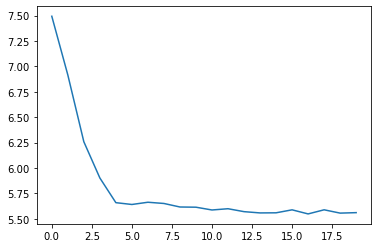

In [19]:
#Let's go !
net = LSTM(100, 20, 20, vocab_size, n_classes, 0.6, None)

train()

In [21]:
def test():
    count = 0
    i = 0
    from collections import Counter
    with torch.no_grad():
        for j, (inputs, targets, length_list) in enumerate(test_dataloader):
            probs = net(inputs, length_list)
            count += Counter((torch.argmax(probs, dim=1) - targets).tolist())[0]
            i = j
    print("acc_val: ", count / (j*batch_size))
    distribution = Counter(y_val)
    print(distribution)
    print([i/len(y_val) for i in distribution.values()])


In [22]:
#test 
test()

acc_val:  0.74375
Counter({2: 581, 3: 181, 1: 157, 4: 57, 0: 24})
[0.057, 0.157, 0.581, 0.181, 0.024]


In [23]:
#get the pre-trained glove embedding vectors
EMBEDDING_SIZE = 100

def read_glove(path):
    #the function copied from yjqiang
    embedding = []
    word2id = {}
    with open(path, 'r', encoding='UTF-8') as f:
        for index, line in enumerate(f):
            line = line.rstrip('\n')  # remove the newline character
            if line:  # 移除空白行
                list_line = line.split()
                embedding.append([float(value) for value in list_line[1:]])
                word2id[list_line[0]] = index  # word = list_line[0]
    return embedding, word2id


list_embedding, word2idx = read_glove("../data/glove.6B.100d.txt")

In [26]:
# build dict & handle unknown word

pad_idx = len(list_embedding)
list_embedding.append(torch.zeros(EMBEDDING_SIZE, dtype=torch.float).tolist())
word2idx['padding'] = pad_idx

unk_idx = len(word2idx)
word2idx['unknown'] = unk_idx

vocab_size = len(word2idx)

tensor_embedding = torch.tensor(list_embedding)
EMBEDDING = nn.Embedding.from_pretrained(tensor_embedding, freeze=False, padding_idx=pad_idx)

In [27]:
#Loss function & Model & optimizer

loss_function = nn.CrossEntropyLoss()

net = LSTM(embedding_dim=100, hidden_dim=20, num_layers=20,
            vocab_size=vocab_size, target_size=n_classes, dropout=0.6, embedding=EMBEDDING)

optimizer = optim.SGD(net.parameters(), lr=0.1)

In [30]:
#get dataloader
train_dataloader = get_dataloader(x_train, y_train)

test_dataloader = get_dataloader(x_val, y_val)

epoch:  0 batch:  1600  time:  12.4 loss:  7.583466410636902
epoch:  0 batch:  3600  time:  22.5 loss:  6.977716326713562
epoch:  1 batch:  1600  time:  31.0 loss:  6.280867099761963
epoch:  1 batch:  3600  time:  40.7 loss:  5.943373203277588
epoch:  2 batch:  1600  time:  50.3 loss:  5.680462121963501
epoch:  2 batch:  3600  time:  59.8 loss:  5.692112445831299
epoch:  3 batch:  1600  time:  1m9.0 loss:  5.644496202468872
epoch:  3 batch:  3600  time:  1m17.6 loss:  5.640551567077637
epoch:  4 batch:  1600  time:  1m26.9 loss:  5.640239715576172
epoch:  4 batch:  3600  time:  1m36.0 loss:  5.623187899589539
epoch:  5 batch:  1600  time:  1m45.4 loss:  5.580963850021362
epoch:  5 batch:  3600  time:  1m54.1 loss:  5.597161173820496
epoch:  6 batch:  1600  time:  2m2.7 loss:  5.574258923530579
epoch:  6 batch:  3600  time:  2m10.9 loss:  5.59045135974884
epoch:  7 batch:  1600  time:  2m19.3 loss:  5.566203236579895
epoch:  7 batch:  3600  time:  2m28.4 loss:  5.5640387535095215
epoch:

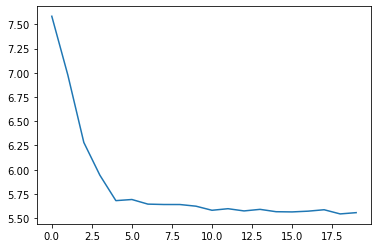

In [31]:
#train the LSTM with pre-train embedding vectors
train()

In [32]:
test()

acc_val:  0.74375
Counter({2: 581, 3: 181, 1: 157, 4: 57, 0: 24})
[0.057, 0.157, 0.581, 0.181, 0.024]


In [ ]:
#Conclusion:Slower but Final Loss Decreases
#Maybe Glove will perform better in bigger dataset but My PC's GPU is GTX1050Ti which didn't support CUDA so I will freeze here now
#LoL ~

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, vocab_size, target_size, dropout, embedding):
        super(TextCNN, self).__init__()
        if embedding:
            self.word_embeddings = embedding
        else:
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(target_size), 2)
        self.pool = GlobalMaxPool1d()
        self.convs = nn.ModuleList()
        for c, k in zip(target_size, [3, 4, 5]):
            self.convs.append(nn.Conv1d(in_channels = embedding_dim, 
                                        out_channels = c, 
                                        kernel_size = k))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        embeds = embeds.permute(0, 2, 1)
        encoding = torch.cat([self.pool(F.relu(conv(embeds))).squeeze(-1) for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs
